# Abe's knot with 23 crossings

## Modules

In [1]:
import numpy as np
import pandas as pd

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

from GridPythonModule import *
from GPM_wrapper import *
from knot_floer_homology import *

# ----- Debugger -----
# from IPython.core.debugger import Pdb; Pdb().set_trace()

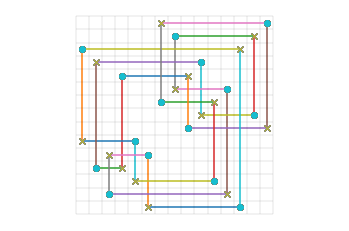

crossing number: 23


In [2]:
abe_knot_grid = [[5,11,4,3,2,0,14,9,10,7,8,1,12,13,6],[12,2,10,1,5,4,8,13,6,11,3,9,0,7,14]]
abe_knot = Grid(*abe_knot_grid)

abe_knot.draw()
print(f"crossing number: {len(abe_knot.crossings)}")

In [3]:
PD = abe_knot.get_PD(); print(f"PD notation: \n {PD}\n")
hfk = pd_to_hfk(PD); print(f"hfk values: \n {hfk}\n")

PD notation: 
 [[40, 45, 41, 0], [7, 45, 8, 44], [24, 42, 25, 41], [42, 24, 43, 23], [43, 7, 44, 6], [4, 25, 5, 26], [5, 23, 6, 22], [17, 9, 18, 8], [16, 39, 17, 40], [15, 1, 16, 0], [30, 9, 31, 10], [31, 39, 32, 38], [32, 1, 33, 2], [11, 19, 12, 18], [10, 29, 11, 30], [36, 19, 37, 20], [37, 29, 38, 28], [21, 13, 22, 12], [20, 35, 21, 36], [26, 13, 27, 14], [27, 35, 28, 34], [3, 15, 4, 14], [2, 33, 3, 34]]

hfk values: 
 {'L_space_knot': False, 'epsilon': 1, 'fibered': True, 'modulus': 2, 'nu': 1, 'ranks': {(-3, -7): 1, (-2, -6): 2, (-2, -3): 2, (-1, -5): 1, (-1, -2): 5, (0, -1): 5, (1, -3): 1, (1, 0): 5, (2, -2): 2, (2, 1): 2, (3, -1): 1}, 'seifert_genus': 3, 'tau': 1, 'total_rank': 27}



'seifert_genus' が 3、'ranks' の最後が (3, -1): 1 となっており、('maslov gr(=genus)', 'alexander gr'): rank  ですから、ラムダは -1 ですね。

In [4]:
for mgr, agr in hfk['ranks'].keys():
    if mgr == hfk['seifert_genus']:
        lmd = agr
output = {'cr': 23, 'seifert_genus': mgr, 'lmd': lmd, 'ranks': hfk['ranks'], 'grid': abe_knot.orig, 'PD notation': PD}
df = pd.DataFrame(output); display(df)

ValueError: arrays must all be same length

## Scratch

In [ ]:
result = []
N, gsize = 100, 30

with tqdm(total=N, desc = '# of required knots') as pbar:
    while len(result) < N:
        ### Collect fitted grids
        Glist, Glist_len = [], 80
        with tqdm(total=Glist_len, desc = 'generating Glist') as pbar_Glist:
            fails, fmax = 0, 100
            while len(Glist) < Glist_len and fails < fmax:
                with Pool(processes=8) as pool:
                    grids = [generate_random_grid(gsize) for _ in range(100)]
                    output = [v for v in pool.map(get_fitted_grid, grids) if v is not None]
                    if len(output) > 0: 
                        Glist += output
                        pbar_Glist.update(len(output))
                    else:
                        fails += 1
            if fails >= fmax:
                print(f"Fail to generate Glist {fails} times!")
                break

        ### Collect knots satisfying seifert genus > lamda
        with Pool(processes=8) as pool:
            output = [v for v in list(tqdm(pool.imap(calc_lmd, Glist), total = len(Glist), desc='hfk calc')) if v is not None]
            if len(output) > 0:
                result += output
                pbar.update(len(output))
#---
DF = pd.DataFrame(result); display(DF)
DF.to_csv(f"./data/big_knots_with_small_lambda.csv", mode = 'a', index=False, header = False) #True)

In [ ]:
flag, count = True, 0
while flag:
    count += 1
    G = generate_random_grid(30);
    Glist = [G, destabilize_all(G), simplify_grid(G)]
    cnlist = list(map(lambda g: crossing_number(g), Glist))
    if cnlist[0] < cnlist[2] or cnlist[0] < cnlist[1]:
        flag = False
        for g in Glist:
            draw_grid(g); print(crossing_number(g))
    if count > 1000:
        flag = False